In [1]:
from fm_flux import FM_CALC
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt

In [2]:
catalog_path = './full_earth_FM_moonrak.npy'

In [22]:
f = np.load(catalog_path)

In [23]:
lat, long, power = f[:,1]*u.deg, f[:,2]*u.deg, f[:,4]*u.kilowatt

In [24]:
lat, long, power

(<Quantity [ 49.090333,  41.45    ,  42.329694, ..., -27.      ,  -9.8     ,
             41.216667] deg>,
 <Quantity [  4.873333,   2.164167,   9.158222, ..., -48.596944, -77.433333,
             19.516667] deg>,
 <Quantity [0.5   , 0.    , 1.    , ..., 1.2273, 0.    , 0.    ] kW>)

In [25]:
#-43.00311 to -12.46113 and longitude from 113.6594 to 153.61194

In [26]:
lat.max(), lat.min(), long.max()

(<Quantity 77.896667 deg>, <Quantity -77.85 deg>, <Quantity 179.988611 deg>)

In [27]:
lat_low_indx = np.where(lat.value<=-12.46113)[0]
lat_low = lat[lat_low_indx]
long_low = long[lat_low_indx]
power_low = power[lat_low_indx]

lat_high_indx = np.where(lat_low.value>=-43.00311)[0]
lat_high = lat_low[lat_high_indx]
long_high = long_low[lat_high_indx]
power_high = power_low[lat_high_indx]

In [28]:
long_low_indx = np.where(long_high.value<=153.61194)[0]
lat_high = lat_high[long_low_indx]
long_high = long_high[long_low_indx]
power_high = power_high[long_low_indx]


long_high_indx = np.where(long_high.value>=113.6594)[0]
lat_high = lat_high[long_high_indx]
long_high = long_high[long_high_indx]
power_high = power_high[long_high_indx]

In [30]:
lat_high.shape, power_high

((3099,), <Quantity [1.e+01, 1.e+01, 1.e+01, ..., 1.e-03, 1.e-03, 1.e-03] kW>)

In [36]:
lat.shape, np.nanmean(power_high), np.nanmean(power)

((171224,), <Quantity 8.40408154 kW>, <Quantity 7.77713935 kW>)

In [33]:
np.nansum(power_high)/np.nansum(power)

<Quantity 0.01955813>

In [3]:
obsID = np.loadtxt('/home/himanshu/pawsey/pha', dtype=np.int32)

OSError: /home/himanshu/pawsey/phase2/moon/scripts/obsIDs_Oct_7_10_2023 not found.

In [4]:
FM_process = FM_CALC(catalog_path=catalog_path)

In [5]:
altaz_dist = FM_process.get_altaz_n_dist(obsID = obsID[0], FM_loc=None, save_as_array=False,)

In [6]:
altaz_dist.shape

(171225, 3)

In [31]:
station_cont=FM_process.get_station_RFIcontributions(obsID=obsID[0], altaz_array=altaz_dist,\
                                                 randomise_zero_power_stations=True,\
                                       save_as_array=False, )

In [32]:
station_cont.shape

(25345, 8)

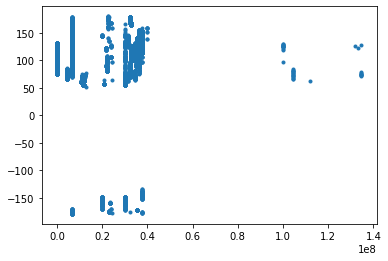

In [35]:
plt.plot(station_cont[:,0], station_cont[:,2], '.')

In [36]:
FMflux = FM_process.get_FM_RFI_flux(obsID=obsID,bandpass='constant', stations_array=station_cont, save_as_array=False,)

UnboundLocalError: local variable 'freq' referenced before assignment

In [ ]:
plt.yscale('log')
plt.plot(FMflux[0], FMflux[1],'.')

In [16]:
def get_station_RFIcontributions(obsID, altaz_array=None, FM_catalog=None, randomise_zero_power_stations=True,\
                                save_as_array=True, savefilename=None, savepath=None):
        
        """
        Get the FM stations contributing in the reflected RFI from the Moon at the given observation time.

        Args:

            obsID (int): GPSTIME at which the Moon's sky location is obtained.
            altaz_array (bool, optional): if True then provide altaz array information, otherwise uses self.instance
            altaz_filename (str, optional): path of the altaz file.
            randomise_zero_power_stations (bool, optional): if randomise the zero/missing power stations based on the non-zeros powered stations
            save_as_array (bool, optional): True if want to save the station array as file
            savefilename (str, optional): if True, provide the filename to save, format:.npy
            savepath    (str, optional): path to save the file
            
        Raises:
            RuntimeError: uses function under main instances
            TypeError: bool required

        Returns:
        
            file or ndarray: FM contribution from where the Moon lying above the horizon during the scheduled observation from given telescope.
            
        """
            
        ## FM catalog includes FM transmitters across the earth.[station ID, lat(deg.), long(deg.), freq(MHz), power(KW)]
        #FM_catalog = self.FM_catlog 
        
        altaz_stations = altaz_array[1:,:]
        altaz_telescope = altaz_array[0]
        
        if altaz_telescope[1]>0: # Moon is above the horizon at the telescope's location for given obsID (GPSTIME)
            
            contributing_stations_index = np.where(altaz_stations[:,1]>=0.)[0] # Moon above horizon at the location of FM stations
            altaz_stations = altaz_stations[contributing_stations_index] 
            FM_catalog = FM_catalog[contributing_stations_index]
            print(FM_catalog)
            if type(randomise_zero_power_stations) != bool:
                raise TypeError('not a bool type')
            
            elif bool(randomise_zero_power_stations) == True:
                ## checking 0 KW power stations (missing data)
                
                nonzero_power_stations_ind = np.where(FM_catalog[:,4]!=0.)[0] 
                mean_power = np.nanmean(FM_catalog[:,4][nonzero_power_stations_ind])
                std_power = np.nanstd(FM_catalog[:,4][nonzero_power_stations_ind]) 
                 
                zero_power_stations_ind = np.where(FM_catalog[:,4]!=0.)[0] 
                
                rand_power = np.random.normal(loc=mean_power, scale=std_power, size=len(zero_power_stations_ind)) 
                ## giving unhealthy stations a random power
                FM_catalog[zero_power_stations_ind, 4] = np.abs(rand_power) # to stations
                    
            elif bool(randomise_zero_power_stations) == False:
                
                # discarding zero powered stations
                FM_catalog = np.delete(FM_catalog, zero_power_stations_ind, axis=0) 
                altaz_stations = np.delete(altaz_stations, zero_power_stations_ind, axis=0)
            # stored data as station ID, lat, long, freq, power, alt, az, distance
            stations = np.concatenate([FM_catalog, altaz_stations], axis=1) # typical shape N x 8
            ## adding telescope location in the zeroth index of the array # shape required 1 x 8
            # stored data as np.nan, lat, long, height, np.nan alt, az, distance (frequency is replaced by height)
            telescope_parameters = np.array([np.nan, self.telescope_loc[0],\
                                                        self.telescope_loc[1],\
                                                            self.telescope_loc[2],\
                                                                np.nan,\
                                                                    altaz_telescope[0], \
                                                                        altaz_telescope[1],\
                                                                            altaz_telescope[2]])
            telescope_parameters = telescope_parameters.reshape(1, len(telescope_parameters))
            stations = np.concatenate([telescope_parameters, stations], axis=0)
            
            if save_as_array == True:
                np.save(savepath+savefilename, stations)   
            else:   
                return stations
        else:
            print("The Moon is below the horizon at telescope's at given GPSTIME!")
            pass


In [ ]:
station_cont[:,3]

In [17]:
FM_process.FM_catlog[:,3]

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
get_station_RFIcontributions(obsID, altaz_array=None, randomise_zero_power_stations=True,\
                                save_as_array=True, savefilename=None, savepath=None)